In [17]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import numpy as np
from scipy.stats import zscore
from scipy.special import logit
from IPython.core.pylabtools import figsize

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
from tqdm import tqdm

from statsmodels.stats.multitest import multipletests

In [2]:
data_dir = '/mnt/lareaulab/cfbuenabadn/data_sc_regulation/data_autocorrelation/'
# data_dir = '../../data/'
tiklova_mrna_event = pd.read_csv(data_dir + 'tiklova_neurogenesis/mrna_per_event.tab', sep='\t', index_col=0)
tiklova_neurogenesis_rd = pd.read_csv(data_dir + 'tiklova_neurogenesis/rd_pc2.tab', sep='\t', index_col=0)
tiklova_PSI = pd.read_csv(data_dir + 'tiklova_neurogenesis/skipped_exons_psi.tab', sep='\t', index_col=0)
tiklova_psix = pd.read_csv('../psix_runs/tiklova_neurogenesis.scores.txt', sep='\t', index_col=0)
tiklova_cross_psix = pd.read_csv('../psix_runs/tiklova_neurogenesis.cross_scores.tab', sep='\t', index_col=0)
tiklova_kw = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/tiklova_neurogenesis_kw.tab', sep='\t', index_col=0)
# tiklova_kw = pd.read_csv(data_dir + 'tiklova_neurogenesis/tiklova_neurogenesis_kw.tab', sep='\t', index_col=0)

In [43]:
tiklova_kw = tiklova_kw.loc[tiklova_psix.index]
tiklova_kw['qvals'] = multipletests(tiklova_kw.pvals, method='fdr_bh')[1]

geary_C = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/tiklova_autocor_one_matrix/tiklova_GearyC_k100.tab',
                     sep='\t', index_col=0)

geary_C.columns = ['C_score', 'pvals']

In [3]:
def get_ranks(scores_df, score_name, bins=50):
    score_series = scores_df.sort_values(score_name).sort_values(score_name)
    ranks_dict = dict()
    total_exons = len(scores_df.index)
    exons_per_rank = int(total_exons/bins)
    for i in range(bins):
        bin_str = i+1
        bin_lims = -exons_per_rank*i
        if i == bins - 1:
            rank_exons = scores_df.sort_values(score_name).index[:bin_lims]
        elif i == 0:
            rank_exons = scores_df.sort_values(score_name).index[bin_lims-exons_per_rank:]
        else:
            
            rank_exons = scores_df.sort_values(score_name).index[bin_lims-exons_per_rank:bin_lims]
        ranks_dict.update({bin_str:rank_exons})
    return ranks_dict
    

def make_comparison(df1, df2, score1, score2, bins=50):
    
    rank_df = pd.DataFrame()
    rank_df_exons = pd.DataFrame()
    
    ranks1 = get_ranks(df1, score1, bins)
    ranks2 = get_ranks(df2, score2, bins)
    
    for i in range(1, bins+1):
        shared_list = []
        shared_exons_list = []
        r1_i = ranks1[i]
        for j in range(1, bins+1):
            r2_j = ranks2[j]
            
            shared = len(r1_i & r2_j)
            
            shared_list.append(len(r1_i & r2_j))
            shared_exons_list.append(r1_i & r2_j)
            
        rank_df['bin_' + str(i)] = shared_list
        rank_df_exons['bin_' + str(i)] = shared_exons_list
        
    rank_df.index = ['bin_' + str(i) for i in range(1, bins+1)]
    rank_df_exons.index = ['bin_' + str(i) for i in range(1, bins+1)]
    
    return rank_df, rank_df_exons
        

Text(50.0, 0.5, 'Psix ranks')

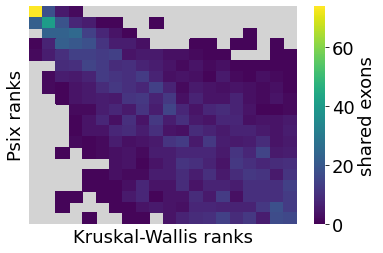

In [4]:
comparison, comparison_exons = make_comparison(tiklova_kw.loc[tiklova_psix.index], tiklova_psix.loc[tiklova_psix.index],
                             'KW_score', 'L_score', bins=20)
mask = comparison == 0
                             
g = sns.heatmap(comparison, mask=mask, cmap='viridis', cbar_kws={'label': 'shared exons'}, 
# g = sns.heatmap(comparison, cmap='viridis', cbar_kws={'label': 'shared exons'}, 
                yticklabels=False, xticklabels=False)
g.set_facecolor('lightgray')

# g.tick_params(labelsize=0)
g.figure.axes[-1].tick_params(labelsize=18)
g.figure.axes[-1].yaxis.label.set_size(18)

plt.xlabel('Kruskal-Wallis ranks', fontsize=18)
plt.ylabel('Psix ranks', fontsize=18)

Text(50.0, 0.5, 'Psix ranks')

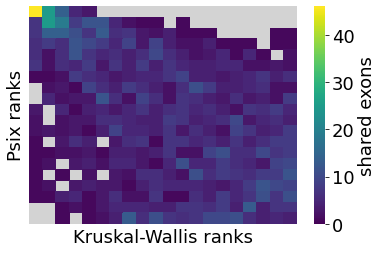

In [44]:
comparison, comparison_exons = make_comparison(geary_C.loc[tiklova_psix.index & geary_C.index], 
                                               tiklova_psix.loc[tiklova_psix.index & geary_C.index],
                             'C_score', 'L_score', bins=20)
mask = comparison == 0
                             
g = sns.heatmap(comparison, mask=mask, cmap='viridis', cbar_kws={'label': 'shared exons'}, 
# g = sns.heatmap(comparison, cmap='viridis', cbar_kws={'label': 'shared exons'}, 
                yticklabels=False, xticklabels=False)
g.set_facecolor('lightgray')

# g.tick_params(labelsize=0)
g.figure.axes[-1].tick_params(labelsize=18)
g.figure.axes[-1].yaxis.label.set_size(18)

plt.xlabel('Kruskal-Wallis ranks', fontsize=18)
plt.ylabel('Psix ranks', fontsize=18)

In [22]:
pos_psix = tiklova_psix.index[(tiklova_psix.qvals <= 0.05) & (tiklova_psix.L_score > 0)] & tiklova_kw.index
pos_kw = tiklova_kw.index[tiklova_kw.qvals <= 0.05] & tiklova_psix.index

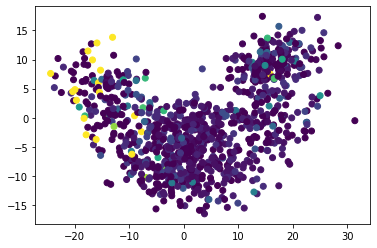

In [7]:
# Exon good for Psix, not for KW
plt.scatter(tiklova_neurogenesis_rd.PC_1, tiklova_neurogenesis_rd.PC_2, 
            c=tiklova_PSI.loc['Snhg11_nmdSE_1', tiklova_neurogenesis_rd.index])

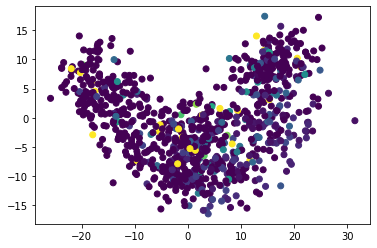

In [7]:
# Exon good for KW, not for Psix
plt.scatter(tiklova_neurogenesis_rd.PC_1, tiklova_neurogenesis_rd.PC_2, 
            c=tiklova_PSI.loc['Syt1_3', tiklova_neurogenesis_rd.index])

In [28]:
# weyn_pvals = pd.read_csv(data_dir + 'weyn/Weyn_pvals.tab', sep='\t', index_col=0)
# weyn_fdr = pd.read_csv(data_dir + 'weyn/Weyn_fdr.tab', sep='\t', index_col=0)
# weyn_psi = pd.read_csv(data_dir + 'weyn/Weyn_psi.tab', sep='\t', index_col=0)

In [30]:
def L_upgma_step(cross_L_matrix, score_min = 0.1):
#     score_min = 0.1
    counter = 1
    for exon in cross_L_matrix.index:
        exon_max = cross_L_matrix.loc[exon].dropna().sort_values().index[-1]
        exon_pair = (exon, exon_max)
        pair_score = cross_L_matrix.loc[exon, exon_max]
        pair_score_r = cross_L_matrix.loc[exon_max, exon]
        if counter == 1:
            max_pair = exon_pair
            max_pair_score = pair_score
            max_pair_score_r = pair_score_r
        else:
            token_1 = (pair_score > max_pair_score) and (pair_score_r >= score_min)
            token_2 = (pair_score >= score_min) and (pair_score_r >= score_min) and (max_pair_score_r < score_min)
            if token_1 or token_2:
                max_pair = (exon, exon_max)
                max_pair_score = cross_L_matrix.loc[exon, exon_max]
                max_pair_score_r = cross_L_matrix.loc[exon_max, exon]
        counter += 1

    if (max_pair_score >= score_min) and (max_pair_score_r >= score_min):
        new_idx = [x for x in cross_L_matrix.index if x not in max_pair]
        new_df = cross_L_matrix.loc[new_idx, new_idx]

        combined_cross_1 = cross_L_matrix.loc[new_idx, list(max_pair)].mean(axis=1)
        combined_cross_2 = cross_L_matrix.loc[list(max_pair), new_idx].mean(axis=0)

        new_df[','.join(max_pair)] = combined_cross_2
        new_df = new_df.T
        new_df[','.join(max_pair)] = list(combined_cross_1) + [0]
        new_df = new_df.T
        
        return new_df
    else:
        print(max_pair_score)
        return [0]
            
            
def get_modules(cross_L_matrix, score_min = 0.0):
    counter = 1
    for i in tqdm(range(len(cross_L_matrix.index))):
        combined_cross = L_upgma_step(cross_L_matrix, score_min)
        if len(combined_cross) == 1:
            return cross_L_matrix
        else:
            cross_L_matrix = combined_cross
            
#         print(counter)
    return cross_L_matrix
        

In [31]:
x = tiklova_psix.sort_values('L_score').index
modules_psix = get_modules(tiklova_cross_psix)

 90%|████████▉ | 669/745 [08:41<00:59,  1.28it/s]

0.0275


In [32]:
modules_psix

,Arfip2_nmdSE_1,Chtf8_3,Lztfl1_3,Lztfl1_5,Pphln1_6,Evl_3,Gpatch8_2,Iffo1_1,Zfp558_1,Zfp558_3,...,"Mgrn1_2,Ece2_4,Sez6_2,Nlgn3_2,Rbm34_1,Snx19_3,Btbd6_1","Zfp266_8,Rbck1_3,Scnm1_1,Ntan1_7","Mycbp2_14,Cacnb3_2","Rhbdl1_1,Atat1_4,Rhbdl1_2,Ttc3_6,Camk2b_5,Tia1_nmdSE_2","Sorbs2_16,Sorbs2_16","Plpp1_2,Nprl3_4,Nptn_1,Rundc3b_2,Gpr85_1,Fbxo44_nmdSE_3,Sorbs2_14,Csnk1d_3,Csnk1d_3,Raf1_3","Tmem255a_2,Trmt2a_1,Arhgap12_4,Bphl_1,Clpx_2,Btbd10_1","Zfp266_9,March8_6,Mpdu1_1,Zcchc17_3,Gapvd1_3,Cdk4_1,Llgl1_2,Mpdu1_nmdSE_2,U2af1_3,Ttc17_4,Bend5_3,Cacul1_2,Snx16_2,Zmiz2_8,Nfyb_1,H13_4,Zfr2_1,Kdm4b_5,Mpv17_4,Trmt10b_3,U2af1_4,Heatr3_2,Dkk3_1,Fam3a_2,Wbp2_2,Pigq_nmdSE_1,Pigq_4,Sgip1_5,Epha5_4,Commd6_1,Ociad1_5,Dync1li2_2,Rsrp1_1,Lrsam1_3,Ewsr1_1,Add1_2,Tbp_4,Abi2_2,Snrpa1_2,Rnf114_1,Cadm1_10,Mbnl1_6,Add1_4,Kif3a_3,Erc2_6,Tcf25_3,Klc1_2,Dlg2_4,Ybx1_1,Ablim2_4,Taz_6,Nr2c2ap_1,Kif21a_12,Shd_2,Clasp1_17,Ltv1_1,Tbp_6,Robo2_1,Apip_1,Tmpo_3,Kif21a_2,Sgip1_2,Sap30bp_5,Cadm3_1,Pdlim7_9,Zmynd8_6,Pdss2_2,Dtnb_16,Mpv17_2,Ccs_2,Tbp_1,Chchd6_1,Rsrc2_8,Myt1l_11,Ipo13_2,Anks1b_7,Madd_8,Zfp512_1,Zfp207_5,Lrrc40_nmdSE_3,Pcbp2_5,Lrrc40_1,Phactr1_2,Mvb12a_1,Crtc1_6,Ubxn7_3,Hecw1_1,Ogdhl_4,Meg3_5,Flot2_2","Meg3_2,Fance_2,Ip6k2_1,Nnat_3,Nnat_2,Nnat_2,Dnajc5_nmdSE_1,Snhg11_nmdSE_2,Sugp2_10,Emc10_7,Emc10_7,Tecr_6,Alcam_1,Yif1a_2,Map4_12,Zfp811_1,Pnkp_3,Tmem134_2,Prkab1_2,Mettl3_6,Dpf1_5,Ythdc1_3","Acss2_2,Fopnl_1,Bscl2_2,Zfp821_3,Ttc3_10,Ktn1_12,Ank2_14,Pja2_1,Rap1gds1_1,Grin1_2,Pcbp2_2,Spint2_nmdSE_1,Clk4_11,Dnaja3_1,Ints10_1,P4htm_1,Las1l_2,Pitpnb_3,Pip5k1c_2,Smarca2_7,Ndufa5_1,Clasp1_16,Ttc3_19,Nap1l4_18,Nnat_6,Nnat_6,Ttc3_11,Mapk8ip3_13,Luc7l_nmdSE_1,Rbm39_nmdSE_8,Ip6k2_3,Dtnb_9,Ckap5_10,Calu_nmdSE_1,Ank2_11,Arhgef9_2,Rbfox2_6,Tsg101_4,Ntan1_9,Ntan1_8,Ntan1_8,Sorbs2_18,Mbnl2_2,Supt5_5,Cadm1_3,Tom1l2_1,Elmo2_2,Nova1_1,Mbnl2_1,Mbnl2_1,Ctnna2_3,Dusp11_1,Caly_1,Mpi_2,Stk38_5,Oprl1_nmdSE_2,Ino80e_9,Sorbs2_15,Usp34_5,Dmtn_2,Dmtn_2,Dnajc6_1,Actr3b_2,Fbxw11_nmdSE_1,Vti1b_2"
Arfip2_nmdSE_1,0.008000,-0.019000,-0.022000,-0.025000,-0.032000,-0.047000,-0.060000,-0.042000,-0.011000,-0.010000,...,-0.007250,-0.003750,-0.000500,-0.009938,-0.008000,-0.001734,-0.002250,-0.002960,-0.010164,-0.014928
Chtf8_3,-0.022000,0.007000,0.005000,0.003000,0.002000,-0.072000,0.051000,-0.080000,0.002000,0.006000,...,0.005438,-0.018250,0.004000,-0.000688,-0.024000,-0.008609,-0.035500,-0.025644,-0.045645,-0.019629
Lztfl1_3,-0.018000,-0.001000,0.007000,0.006000,-0.006000,-0.016000,-0.082000,-0.126000,-0.025000,-0.007000,...,-0.003750,-0.006000,-0.013500,-0.009063,0.009000,-0.002828,-0.012875,-0.016218,-0.026863,-0.018873
Lztfl1_5,-0.017000,0.001000,0.006000,0.007000,-0.007000,-0.096000,-0.152000,-0.105000,0.005000,0.006000,...,-0.009188,-0.006000,-0.016500,-0.009250,-0.002000,-0.006859,-0.014125,-0.022852,-0.033582,-0.019292
Pphln1_6,-0.021000,0.013000,-0.011000,-0.014000,0.005000,-0.040000,-0.044000,-0.112000,-0.016000,-0.004000,...,-0.001688,-0.020250,0.004500,-0.022312,0.013000,-0.018312,-0.032250,-0.029277,-0.035699,-0.016828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Plpp1_2,Nprl3_4,Nptn_1,Rundc3b_2,Gpr85_1,Fbxo44_nmdSE_3,Sorbs2_14,Csnk1d_3,Csnk1d_3,Raf1_3",-0.019156,-0.057594,-0.045813,-0.053172,-0.043719,-0.028875,-0.004625,-0.038875,-0.106141,-0.069281,...,-0.006123,-0.023184,-0.003133,-0.017077,0.024813,0.000000,-0.026883,-0.026903,0.001088,-0.027558
"Tmem255a_2,Trmt2a_1,Arhgap12_4,Bphl_1,Clpx_2,Btbd10_1",-0.004750,-0.030625,-0.028125,-0.028250,-0.021375,-0.011125,-0.023125,-0.006375,-0.018375,-0.007000,...,-0.038063,-0.008094,-0.027000,-0.028156,-0.024250,-0.016047,0.000000,-0.000778,-0.014665,-0.005014
"Zfp266_9,March8_6,Mpdu1_1,Zcchc17_3,Gapvd1_3,Cdk4_1,Llgl1_2,Mpdu1_nmdSE_2,U2af1_3,Ttc17_4,Bend5_3,Cacul1_2,Snx16_2,Zmiz2_8,Nfyb_1,H13_4,Zfr2_1,Kdm4b_5,Mpv17_4,Trmt10b_3,U2af1_4,Heatr3_2,Dkk3_1,Fam3a_2,Wbp2_2,Pigq_nmdSE_1,Pigq_4,Sgip1_5,Epha5_4,Commd6_1,Ociad1_5,Dync1li2_2,Rsrp1_1,Lrsam1_3,Ewsr1_1,Add1_2,Tbp_4,Abi2_2,Snrpa1_2,Rnf114_1,Cadm1_10,Mbnl

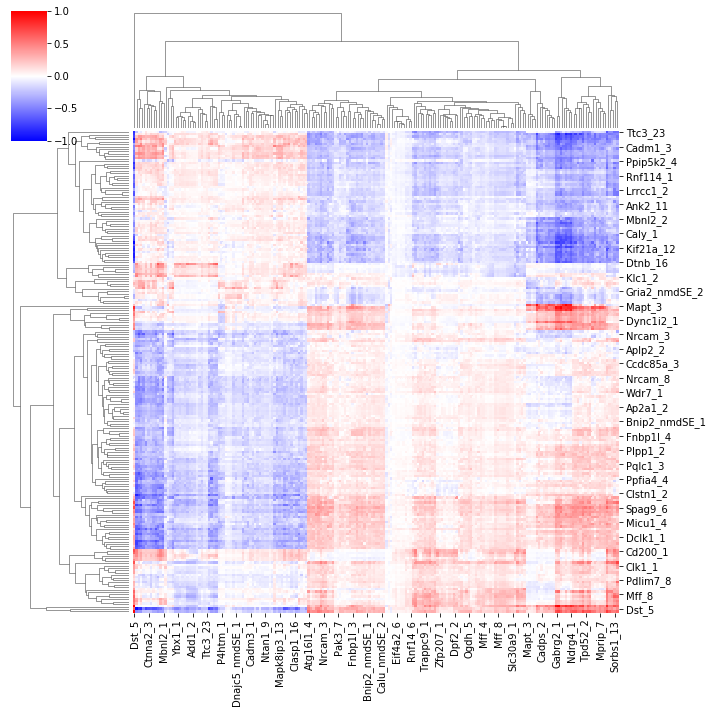

In [39]:
sns.clustermap(tiklova_cross_psix.loc[x, x], vmin=-1, vmax=1, cmap='bwr')

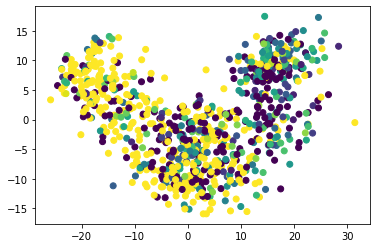

In [56]:
# Exon good for KW, not for Psix
plt.scatter(tiklova_neurogenesis_rd.PC_1, tiklova_neurogenesis_rd.PC_2, 
            c=tiklova_PSI.loc['Ntan1_9', tiklova_neurogenesis_rd.index])

In [33]:
# css_out = get_modules(cross_super_sig, 0.01)
clusters = {}
counter = 0
for cluster in modules_psix.index:
    if len(cluster.split(',')) >= 10:
        clusters.update({counter:cluster.split(',')})
        counter += 1

In [34]:
clusters

{0: ['Ddx39_nmdSE_1',
  'Patz1_4',
  'Patz1_3',
  'Prpf40a_nmdSE_2',
  'Atxn7l1_2',
  'Limk2_2',
  'Sars_5',
  'Zfp280d_14',
  'Rars_2',
  'Macf1_12',
  'Dync1i2_4',
  'Clasp1_3',
  'Mvd_1',
  'Macf1_11'],
 1: ['Ndufs1_13',
  'Ndufs1_7',
  'Zc3h14_11',
  'Ntm_3',
  'Ktn1_13',
  'Cadm1_2',
  'Wiz_nmdSE_1',
  'Chl1_4',
  'Atp6v1h_5',
  'Rsrp1_2',
  'Ntan1_1',
  'Map4_15',
  'Morf4l2_7',
  'Morf4l2_7',
  'Cadm2_1',
  'Peg3_nmdSE_1',
  'Kctd17_3',
  'Gtf2h1_3',
  'Krit1_nmdSE_1'],
 2: ['Ncdn_1',
  'Zfp846_1',
  'Ntan1_6',
  'Tpm3_2',
  'Slc25a33_1',
  'Dnm2_5',
  'Pde9a_6',
  'Camsap3_5',
  'Rpain_1',
  'Fbxw11_5'],
 3: ['Srsf10_nmdSE_1',
  'Aplp2_2',
  'Aplp2_2',
  'Atf2_8',
  'Hnrnpdl_nmdSE_1',
  'Hnrnpdl_nmdSE_1',
  'Pak3_7',
  'Itsn1_1',
  'Csnk1a1_3',
  'Srsf2_1',
  'Ncam1_4',
  'Ncam1_4',
  'Meg3_9',
  'Tk2_2',
  'Iqsec3_3',
  'Ktn1_17'],
 4: ['Hnrnpll_nmdSE_1',
  'Zfand6_5',
  'Zcrb1_nmdSE_1',
  'Snrpb_nmdSE_1',
  'Kansl1_3',
  'Eef1d_10',
  'Adgrb2_3',
  'Mpg_nmdSE_1',
  'Rbm39_nmd

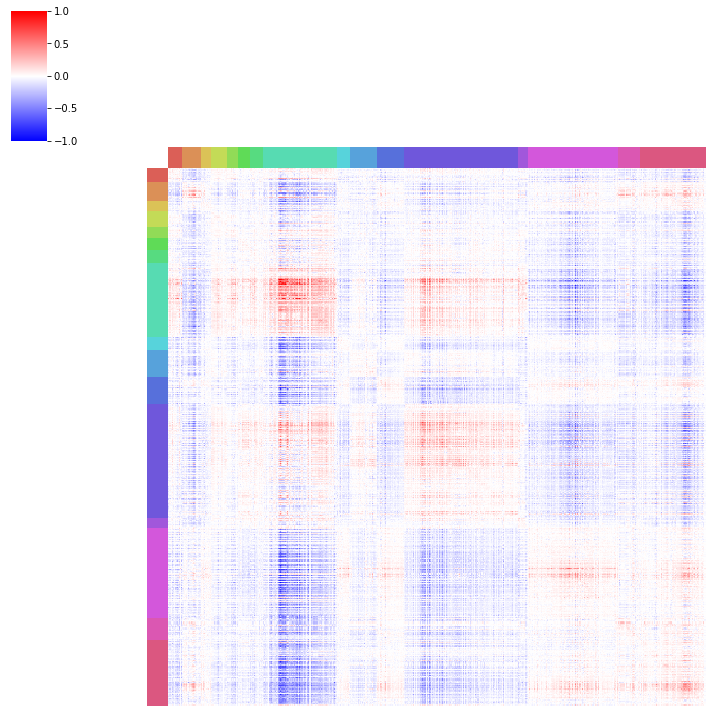

In [42]:
exons_list = []
for i in range(len(clusters.keys())):
# for i in [4, 0, 2, 3, 5, 1]:
    exons_list.extend(clusters[i])
    
colores = sns.color_palette("hls", 16)
exons_list = []
color_list = []
for i in clusters.keys():
    exons_list.extend(clusters[i])
    color_list.extend([colores[i]]*len(clusters[i]))
    
sns.clustermap(tiklova_cross_psix.loc[exons_list, exons_list], col_cluster=False, row_cluster=False,
               col_colors=color_list, row_colors = color_list, cmap='bwr', vmin=-1, vmax=1,
              yticklabels=0, xticklabels=0)

In [40]:
colores

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7178666666666667, 0.33999999999999997),
 (0.6554666666666664, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.33999999999999997, 0.86, 0.7178666666666667),
 (0.33999999999999997, 0.6554666666666664, 0.86),
 (0.3712, 0.33999999999999997, 0.86),
 (0.7178666666666661, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6554666666666664)]

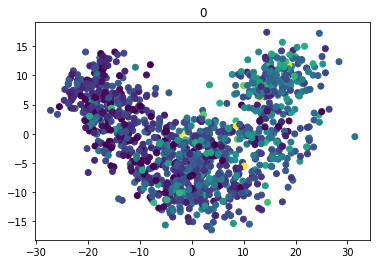

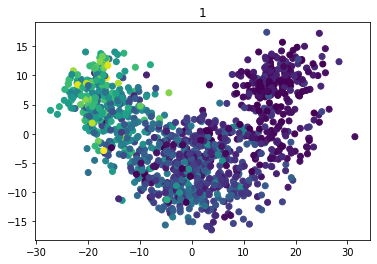

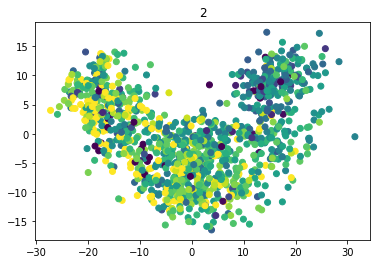

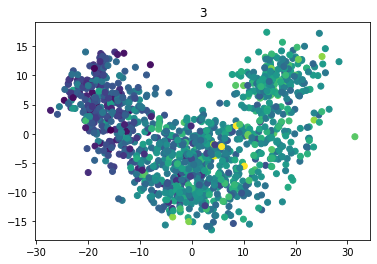

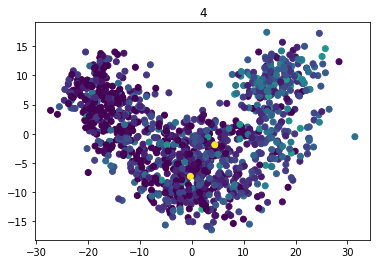

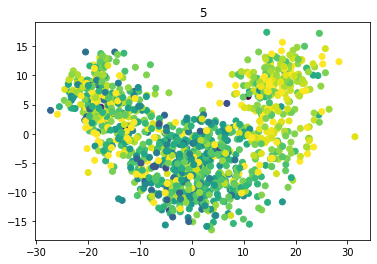

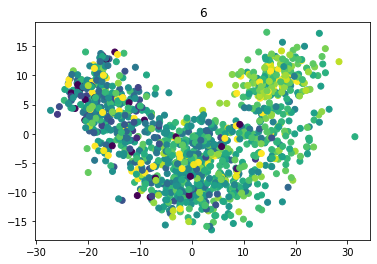

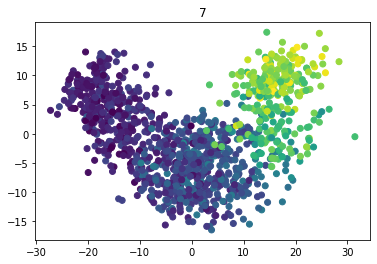

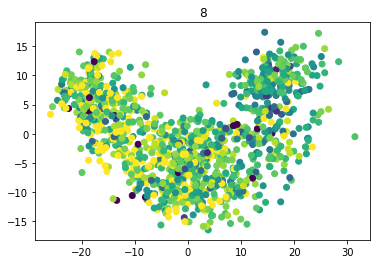

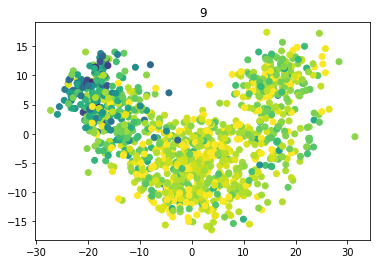

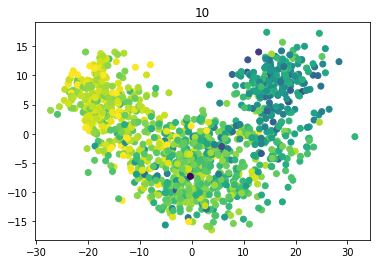

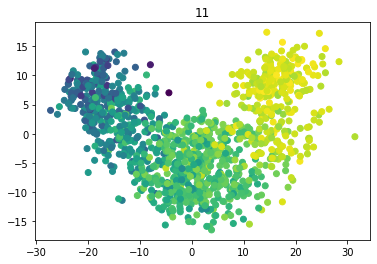

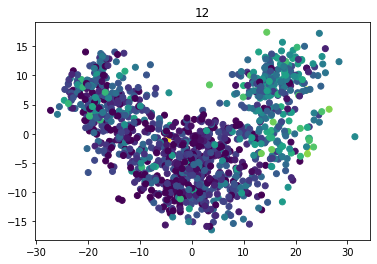

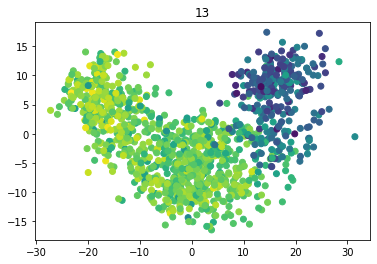

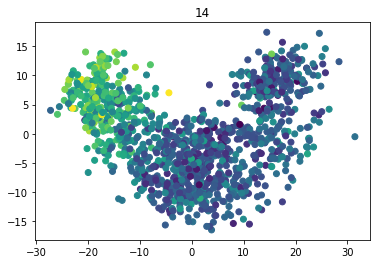

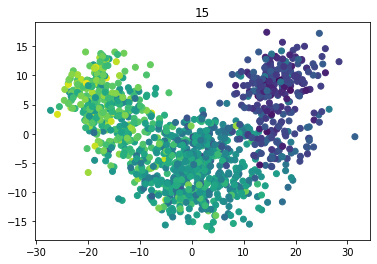

In [45]:
for i in clusters.keys():
    plt.scatter(tiklova_neurogenesis_rd.PC_1, tiklova_neurogenesis_rd.PC_2, 
                c = tiklova_PSI.loc[clusters[i]].mean(axis=0))
    plt.title(i)
    plt.show()

In [63]:
exons_list

['Dnajc5_nmdSE_1',
 'Chl1_4',
 'Peg3_nmdSE_1',
 'Atp6v1h_5',
 'Rsrp1_2',
 'Ntan1_1',
 'Map4_15',
 'Morf4l2_7',
 'Morf4l2_7',
 'Sugp2_10',
 'Nnat_3',
 'Nnat_2',
 'Nnat_2',
 'Meg3_2',
 'Kcnip1_1',
 'Cadps_2',
 'Lrrfip2_7',
 'Srsf9_nmdSE_1',
 'Kif3a_1',
 'Mapt_1',
 'Dst_5',
 'Gabrg2_1',
 'Ndrg4_1',
 'Ndrg4_1',
 'Dbn1_1',
 'C2cd5_4',
 'Spag9_6',
 'Dst_6',
 'Tpd52_2',
 'Stxbp1_2',
 'Clta_4',
 'Mprip_7',
 'Kcnq2_8',
 'Rbm3_nmdSE_1',
 'Ablim2_6',
 'Ncam1_6',
 'Spag9_12',
 'Prpf18_1',
 'Mapt_3',
 'Sh3kbp1_1',
 'C2cd5_2',
 'Micu1_4',
 'Micu1_4',
 'Dync1i2_1',
 'Clstn1_2',
 'Dync1i2_4',
 'Gphn_7',
 'Cog1_1',
 'Tsg101_4',
 'Zfp811_1',
 'Zfp811_1',
 'Dlg1_10',
 'Lrrcc1_2',
 'Nap1l4_18',
 'Ank2_11',
 'Map4_12',
 'Nnat_6',
 'Nnat_6',
 'Ttc3_11',
 'Mapk8ip3_13',
 'Ldhb_1',
 'Nup54_1',
 'Dpf2_2',
 'Ndufa6_1',
 'Arfgap1_7',
 'Aplp2_3',
 'Lysmd4_3',
 'Eif4a2_6',
 'Clk1_1',
 'Nfasc_9',
 'Ap1b1_4',
 'Wdr7_1',
 'Mff_4',
 'Mars_3',
 'Dclk2_3',
 'Rnf14_6',
 'Trappc9_1',
 'G3bp2_4',
 'Cltb_2',
 'Sorbs1_13',
 

In [ ]:
sns.clustermap(tiklova_cross_L.loc[exons_list, exons_list], col_cluster=False, row_cluster=False,
               col_colors=color_list, row_colors = color_list, cmap='bwr', vmin=-2, vmax=2,
              yticklabels=0, xticklabels=0)